In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
df

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [2]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

In [3]:
df['timestamp_int'] = df['timestamp'].values.astype(np.int64) // 10 ** 9
df.head()

,userId,movieId,rating,timestamp,timestamp_int
4182421,28507,1176,4.0,1995-01-09 11:46:44,789652004
18950979,131160,1079,3.0,1995-01-09 11:46:49,789652009
18950936,131160,47,5.0,1995-01-09 11:46:49,789652009
18950930,131160,21,3.0,1995-01-09 11:46:49,789652009
12341178,85252,45,3.0,1996-01-29 00:00:00,822873600


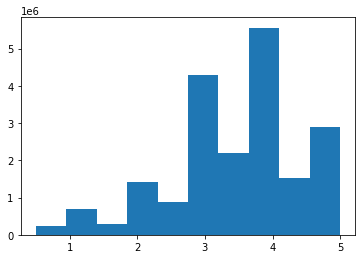

In [4]:
import matplotlib.pyplot as plt

plt.hist(df['rating'].values);

In [5]:
df = df.rename(columns={"userId": "userId:token", "movieId": "movieId:token", "timestamp_int": "timestamp:float"})


In [6]:
test_part = 0.2
train_len = int(df.shape[0] * (1 - test_part))
test_len = df.shape[0] - train_len 
df_train, df_test = df.drop(['timestamp'], axis=1).head(train_len), df.drop(['timestamp'], axis=1).tail(test_len)

In [7]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
from tqdm.auto import trange


class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, df, n_users_total, n_items_total, batch_size): 
        self.n_users_total = n_users_total
        self.n_items_total = n_items_total
        self.batch_size = batch_size
        self.users_history = [[] for _ in range(self.n_items_total)]
        for i in trange(df.shape[0]):
            cur_user = df['userId:token'].iloc[i]
            cur_item = df['movieId:token'].iloc[i]
            cur_rating = df['rating'].iloc[i]
            self.users_history[cur_item].append((cur_user, cur_rating))
        
    def __getitem__(self, index):
        answer = torch.zeros(self.n_users_total)
        for user, rating in self.users_history[index]:
            answer[user] = rating
        return answer

    def __len__(self):
        return len(self.users_history)

In [9]:
dataset = RatingDataset(df_train, df['userId:token'].max() + 1, df['movieId:token'].max() + 1, 8)

  0%|          | 0/16000210 [00:00<?, ?it/s]

In [10]:
loader = torch.utils.data.DataLoader(dataset, batch_size=32)

In [11]:
N_TOTAL = df['userId:token'].max() + 1

In [12]:
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, hidden2_dim, hidden_dim):
        super().__init__()


        self.encoder_common = nn.Sequential(
            nn.Linear(N_TOTAL, hidden2_dim),
            nn.ReLU(),
            nn.Linear(hidden2_dim, hidden_dim),
            nn.ReLU()
        )
        self.encoder_mu = nn.Linear(hidden_dim, hidden_dim) 
        self.encoder_sigma = nn.Linear(hidden_dim, hidden_dim) 
        self.decoder_common = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden2_dim)
        )
        self.decoder_mu = nn.Linear(hidden2_dim, N_TOTAL)
        self.decoder_sigma = nn.Linear(hidden2_dim, N_TOTAL)


    def gaussian_sampler(self, mu, logsigma):
        noise = torch.randn_like(mu)
        return noise * logsigma.exp() + mu

    def encode(self, x):
        hidden = self.encoder_common(x)
        mu = self.encoder_mu(hidden)
        sigma = self.encoder_sigma(hidden)
        return mu, sigma

    def decode(self, mu, sigma):
        sample = self.gaussian_sampler(mu, sigma)
        hidden = self.decoder_common(sample)
        decoded_mu, decoded_sigma = self.decoder_mu(hidden), self.decoder_sigma(hidden)
        return decoded_mu, decoded_sigma

    def forward(self, x):
        latent_mu, latent_logsigma = self.encode(x)
        reconstruction_mu, reconstruction_logsigma = self.decode(latent_mu, latent_logsigma)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma


In [13]:
import math

def KL_divergence(mu, logsigma):
    return -0.5 * torch.sum(1 + 2 * logsigma - mu ** 2 - torch.exp(logsigma) ** 2)


def log_likelihood(x, mu, logsigma):
    sigma = torch.exp(logsigma)
    pi2 = (2 * math.pi) ** 0.5
    return torch.sum(-( (x - mu) ** 2 / (2 * sigma ** 2)) + torch.log(1 / (sigma * pi2)))


def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return -log_likelihood(x, mu_gen, logsigma_gen) + KL_divergence(mu_z, logsigma_z)


In [14]:
vae = VAE(16, 64).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
train_history, dev_history = [], []


In [15]:
torch.save(vae, 'vae.pt')

In [16]:
from tqdm.auto import trange, tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

EPOCHS = 20

for epoch in trange(EPOCHS):
    i = 0
    for batch in tqdm(loader):
        optimizer.zero_grad()
        reconstruction = vae(batch[0].to(device))
        loss = loss_vae(batch[0].to(device), *reconstruction)
        loss.backward()
        optimizer.step()
        train_history.append((len(train_history), loss.item()))
        if len(train_history) % 100 == 0 and len(train_history) > 0 and False:
            clear_output(True)
            plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
            plt.legend(); plt.grid(); plt.show()
            if len(dev_history):
                plt.plot(*zip(*dev_history), color='red', label='dev_loss')
            plt.legend(); plt.grid(); plt.show()
        i += 1
        if i % 10000 == 0:
            print(i)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 0/4102 [00:00<?, ?it/s]

In [17]:
vectors = []

with torch.no_grad():
    for i in trange(len(dataset)):
        cur_vector, _ = vae.encode(dataset[i].unsqueeze(0))
        vectors.append(cur_vector.squeeze(0).cpu().numpy())

  0%|          | 0/131263 [00:00<?, ?it/s]

In [18]:
!pip install nearpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 253.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.2/234.2 kB 848.1 kB/s eta 0:00:00


In [19]:
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
from nearpy.distances import EuclideanDistance

class KNN:
    def __init__(self, data_vec):
        self.data_vec = data_vec
        self.rbp = RandomBinaryProjections('default', 80)
        self.engine = Engine(data_vec.shape[1], lshashes=[self.rbp], distance=EuclideanDistance())
        for index in range(len(data_vec)):
            self.engine.store_vector(data_vec[index], index)

    def find_neighbours(self, query, k=80):
        neighb = self.engine.neighbours(query)[:k]
        return [cur[1] for cur in neighb]

In [20]:
knn = KNN(np.array(vectors))

In [21]:
from math import log2

def apk(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = len(target) 
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            cnt += 1
            ans += cnt / (i + 1)
            s.add(pred[i])
    return ans / tot


def mapk(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += apk(cur_pred, cur_target, k)
    return sum_metric / len(pred) 


def mr(pred, target):
    ans, cnt = 0, 0
    tot = len(target)
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1 / (i + 1)
            s.add(pred[i])
    return ans / tot

def mrr(pred, target):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += mr(cur_pred, cur_target)
    return sum_metric / len(pred) 


def ndcgunique(pred, target):
    ans, cnt = 0, 0
    tot = len(target)
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1 / (log2(i + 2))
            s.add(pred[i])
    return ans / tot

def ndcg(pred, target):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += ndcgunique(cur_pred, cur_target)
    return sum_metric / len(pred) 


def precisionunique(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = len(target) 
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1
            s.add(pred[i])
    return ans / tot


def precision(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += precisionunique(cur_pred, cur_target, k)
    return sum_metric / len(pred) 

In [22]:
g_test = [[] for i in range(df['userId:token'].max() + 1)]
for i in trange(df_test.shape[0]):
    usr, item = df_test['userId:token'].iloc[i], df_test['movieId:token'].iloc[i]
    g_test[usr].append(item)

  0%|          | 0/4000053 [00:00<?, ?it/s]

In [23]:
g_train = [[] for i in range(df_train['userId:token'].max() + 1)]
for i in range(df_train.shape[0]):
    cur_user = df['userId:token'].iloc[i]
    cur_item = df['movieId:token'].iloc[i]
    cur_rating = df['rating'].iloc[i]
    g_train[cur_user].append((cur_rating, cur_item))

for i in range(len(g_train)):
    g_train[i] = sorted(g_train[i])
    g_train[i] = g_train[i][-5:]

In [24]:
predictions = []
target = []
k = 40
for i in trange(df_train['userId:token'].max() + 1):
    if len(g_test[i]) == 0:
        continue
    
    out = []
    for l in g_train[i]:
        cur_item = l[1]
        neighb = knn.find_neighbours(vectors[cur_item], k // 5)
        for e in neighb:
            out.append(e)
    predictions.append(out)
    target.append(g_test[i])


  0%|          | 0/138494 [00:00<?, ?it/s]

In [25]:
for i in range(1, 20):
    print(f"precision@{i} : {precision(predictions, target, i)}")
print(f"ndcg: {ndcg(predictions, target)}")
print(f"mrr: {mrr(predictions, target)}")
for i in range(1, 20):
    print(f"mapk@{i} : {mapk(predictions, target, i)}")

precision@1 : 0.0
precision@2 : 0.0002987577489993314
precision@3 : 0.00038420716543522364
precision@4 : 0.00039685634870608946
precision@5 : 0.0003971912109933591
precision@6 : 0.0004045916993900507
precision@7 : 0.0004974165432254667
precision@8 : 0.0005074079548496308
precision@9 : 0.0005074079548496308
precision@10 : 0.0005074079548496308
precision@11 : 0.0005074079548496308
precision@12 : 0.0005074079548496308
precision@13 : 0.0005074079548496308
precision@14 : 0.0005074079548496308
precision@15 : 0.0005074079548496308
precision@16 : 0.0005074079548496308
precision@17 : 0.0005074079548496308
precision@18 : 0.0005074079548496308
precision@19 : 0.0005074079548496308
ndcg: 0.0002735267715048098
mrr: 0.00019683431474909078
mapk@1 : 0.0
mapk@2 : 0.0001493788744996657
mapk@3 : 0.00018402317881828574
mapk@4 : 0.0001881799045037732
mapk@5 : 0.00018829105856947874
mapk@6 : 0.00019013838877025244
mapk@7 : 0.0002068119807445081
mapk@8 : 0.00020865454862149268
mapk@9 : 0.00020865454862149268
